### Description of the Project

In [380]:
%matplotlib notebook
import numpy as np
import pandas as pd
import json
from datetime import datetime
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from pdpbox import pdp, info_plots
from sklearn.preprocessing import normalize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(5, 2), 'legend.loc':'right'})

### 1. Read Data

In [384]:
with open("../dataset/city_searches.json") as h:
    data = pd.DataFrame(json.load(h))

### 2. Exploratory Data Analysis

In [385]:
for col in data.columns:
    data[col] = data[col].map(lambda x: x[0])
    if col == data.columns[-1]: 
        data[col] = data[col].map(lambda x: x[0])
data.head()

,session_id,unix_timestamp,cities,user
0,D258NVMV202LS,1442640552,"San Jose CA, Montreal QC","{'user_id': 5749, 'joining_date': '2015-04-02'..."
1,TDG10UKG7I4LR,1432110137,New York NY,"{'user_id': 10716, 'joining_date': '2015-03-30..."
2,OH4ZDIGN9BLQS,1437049311,"Montreal QC, Quebec QC","{'user_id': 2941, 'joining_date': '2015-03-16'..."
3,CWHIAYKQ7RA28,1432215908,Chicago IL,"{'user_id': 2164, 'joining_date': '2015-03-27'..."
4,GI8GZJAWAC80P,1443556226,"Toronto ON, Houston TX","{'user_id': 10493, 'joining_date': '2015-03-31..."


In [386]:
# user_info = data.apply(lambda s: pd.Series(s["user"]), axis=1)
data["timestamp"] = pd.to_datetime(data.unix_timestamp, unit='s')

In [387]:
data = pd.concat([data, user_info], axis=1).drop(["user", "unix_timestamp"], axis=1)
data.head()

,session_id,cities,timestamp,user_id,joining_date,country
0,D258NVMV202LS,"San Jose CA, Montreal QC",2015-09-19 05:29:12,5749,2015-04-02,FR
1,TDG10UKG7I4LR,New York NY,2015-05-20 08:22:17,10716,2015-03-30,DE
2,OH4ZDIGN9BLQS,"Montreal QC, Quebec QC",2015-07-16 12:21:51,2941,2015-03-16,
3,CWHIAYKQ7RA28,Chicago IL,2015-05-21 13:45:08,2164,2015-03-27,FR
4,GI8GZJAWAC80P,"Toronto ON, Houston TX",2015-09-29 19:50:26,10493,2015-03-31,US


In [388]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   session_id    20022 non-null  object        
 1   cities        20022 non-null  object        
 2   timestamp     20022 non-null  datetime64[ns]
 3   user_id       20022 non-null  int64         
 4   joining_date  20022 non-null  object        
 5   country       20022 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 938.7+ KB


### 3. Tasks
#### Part 1. There was a bug in the code and one country didn’t get logged. It just shows up as an empty field (“”). Can you guess which country was that? How?

In [389]:
data["hour"] = data["timestamp"].apply(lambda x: x.hour)
data.head(2)

,session_id,cities,timestamp,user_id,joining_date,country,hour
0,D258NVMV202LS,"San Jose CA, Montreal QC",2015-09-19 05:29:12,5749,2015-04-02,FR,5
1,TDG10UKG7I4LR,New York NY,2015-05-20 08:22:17,10716,2015-03-30,DE,8


In [390]:
hourly_searches = data.groupby("country").apply(lambda df: df.groupby("hour").session_id.count()).unstack().fillna(0)
hourly_searches

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
country,,,,,,,,,,,,,,,,,,,,,
,45.0,99.0,169.0,221.0,279.0,262.0,263.0,262.0,276.0,300.0,...,13.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DE,0.0,0.0,3.0,8.0,34.0,86.0,166.0,244.0,365.0,384.0,...,391.0,303.0,164.0,80.0,39.0,12.0,1.0,0.0,0.0,0.0
ES,0.0,0.0,0.0,8.0,13.0,45.0,84.0,111.0,165.0,196.0,...,169.0,155.0,88.0,52.0,11.0,4.0,0.0,0.0,0.0,0.0
FR,0.0,0.0,1.0,6.0,18.0,47.0,97.0,192.0,235.0,262.0,...,233.0,156.0,109.0,58.0,25.0,4.0,1.0,0.0,0.0,0.0
IT,0.0,0.0,1.0,4.0,20.0,34.0,79.0,134.0,169.0,182.0,...,180.0,139.0,96.0,47.0,19.0,8.0,1.0,0.0,0.0,0.0
UK,0.0,0.0,0.0,5.0,10.0,33.0,85.0,163.0,269.0,362.0,...,383.0,381.0,289.0,179.0,86.0,33.0,10.0,6.0,1.0,0.0
US,196.0,98.0,62.0,18.0,6.0,0.0,0.0,0.0,0.0,0.0,...,183.0,270.0,361.0,362.0,346.0,356.0,379.0,347.0,372.0,242.0


<IPython.core.display.Javascript object>


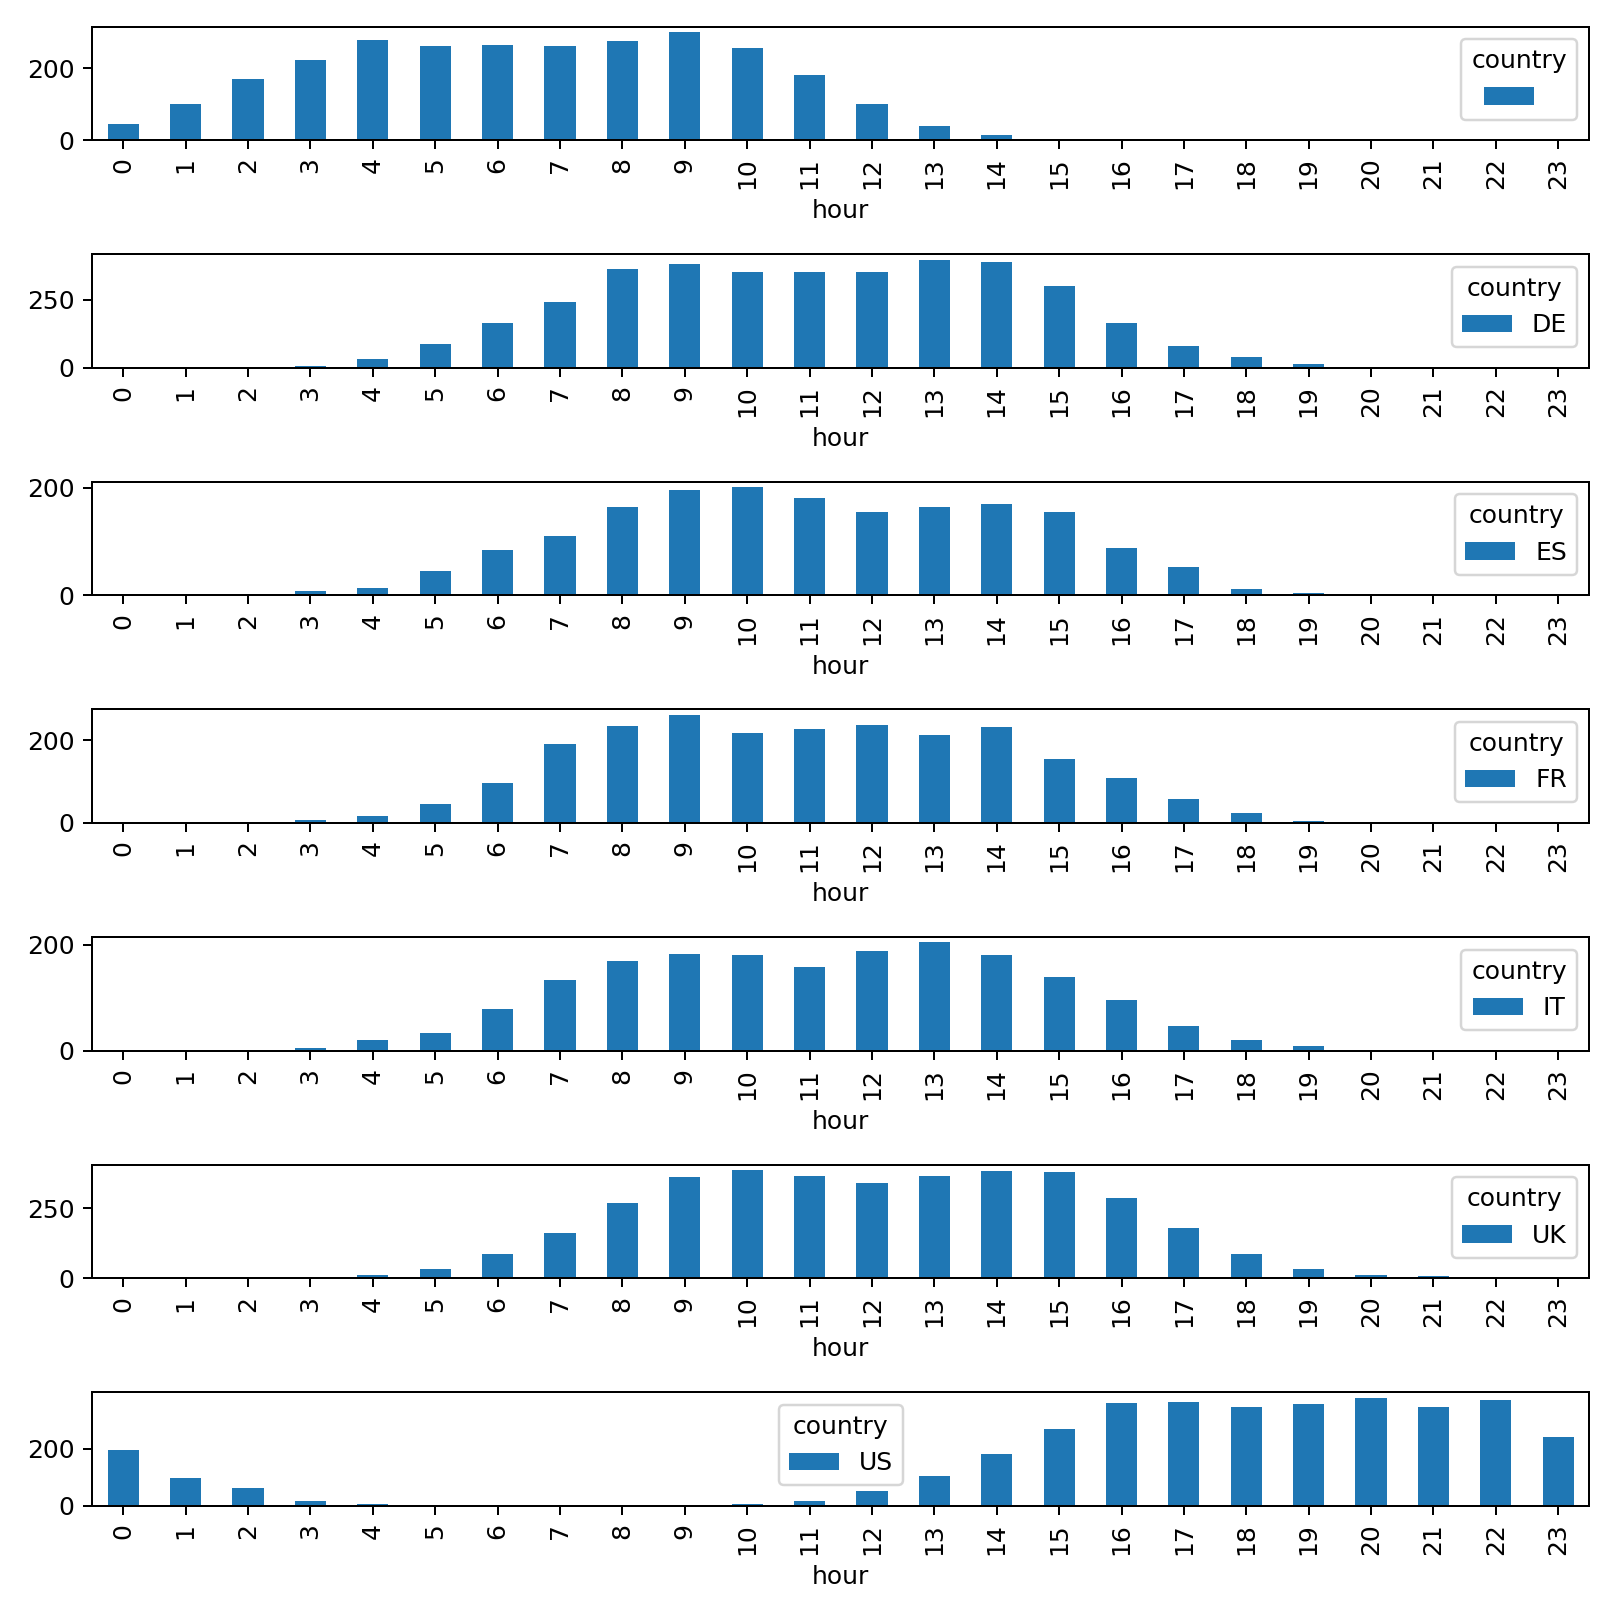

In [391]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(5, 5))
countries = hourly_searches.index
for i in range(len(countries)): 
    _ = hourly_searches[hourly_searches.index==countries[i]].T.plot(kind="bar",  ax=ax[i])

From the 12-hour time difference between the country "" and US, and the 6-hour time difference between the country "" and European contries, I believe "" is an Asian country, for example China.

#### Part 2. For each city, find the most likely city to be also searched for within the same session.

In [392]:
# here I use cosine similarity of user's searched cities.
data['cities'] = data.cities.str.split(', ')
def count_cities(df):
    c = Counter(city for cities in df.cities for city in cities)
    return pd.Series(c)

In [398]:
citycounts_by_user = data.groupby("user_id").apply(count_cities).unstack(fill_value=0)
citycounts_by_user_nrm = normalize(citycounts_by_user, axis=0)

col = citycounts_by_user.columns
similarity_matrix = pd.DataFrame(citycounts_by_user_nrm.T.dot(citycounts_by_user_nrm), columns=col, index=col)
similarity_matrix.head()

,Anaheim CA,Arlington TX,Atlanta GA,Austin TX,Bakersfield CA,Baltimore MD,Birmingham AL,Boston MA,Buffalo NY,Calgary AB,...,Toledo OH,Toronto ON,Tucson AZ,Tulsa OK,Vancouver BC,Victoria BC,Virginia Beach VA,WASHINGTON DC,Wichita KS,Windsor ON
Anaheim CA,1.000000,0.034157,0.024398,0.022908,0.057505,0.027524,0.00000,0.017528,0.009858,0.024836,...,0.005832,0.082593,0.015430,0.000000,0.043104,0.021289,0.018898,0.006855,0.024398,0.021277
Arlington TX,0.034157,1.000000,0.016667,0.245171,0.015713,0.016116,0.00000,0.023947,0.033672,0.027146,...,0.007968,0.041841,0.021082,0.073030,0.044169,0.011635,0.000000,0.000000,0.066667,0.000000
Atlanta GA,0.024398,0.016667,1.000000,0.000000,0.039284,0.000000,0.46291,0.000000,0.000000,0.008483,...,0.019920,0.009509,0.000000,0.000000,0.015775,0.000000,0.000000,0.000000,0.000000,0.000000
Austin TX,0.022908,0.245171,0.000000,1.000000,0.012295,0.016814,0.00000,0.014053,0.042155,0.026551,...,0.006235,0.051589,0.000000,0.028571,0.052664,0.027311,0.000000,0.007328,0.000000,0.007582
Bakersfield CA,0.057505,0.015713,0.039284,0.012295,1.000000,0.012662,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.026896,0.000000,0.000000,0.004957,0.000000,0.000000,0.000000,0.000000,0.000000


In [399]:
d = {}
for city in similarity_matrix:
    d[city] = (similarity_matrix[city].sort_values(ascending=False).index[1],
               similarity_matrix[city].sort_values(ascending=False).values[1])

In [400]:
def func(cities):
    cities.sort(reverse=True, key=lambda x: d[x][1])
    return d[cities[0]][0]
func(["San Jose CA", "Montreal QC"])

'Oakland CA'

In [407]:
data["most_likely_next_city_searched"] = data["cities"].map(func)
next_city_searched_df = data[["cities", "most_likely_next_city_searched"]]
next_city_searched_df.head(5)

,cities,most_likely_next_city_searched
0,"[San Jose CA, Montreal QC]",Oakland CA
1,[New York NY],Jersey City NJ
2,"[Montreal QC, Quebec QC]",New York NY
3,[Chicago IL],Milwaukee WI
4,"[Toronto ON, Houston TX]",New York NY


In [408]:
next_city_searched_df.to_csv("../dataset/most_likely_next_city_searched.csv", index=False, header=True)

#### Part 3. come up with an algorithm that clusters sessions into two groups: high intent and low intent. Explain all assumptions you make along the way.

In [411]:
def avg_distance(cities):
    n = len(cities)
    tot_distances = 0
    for i in range(n):
        for j in range(i+1, n):
            tot_distances += 1 - similarity_matrix.loc[cities[i], cities[j]]
            
    return tot_distances / n

<IPython.core.display.Javascript object>


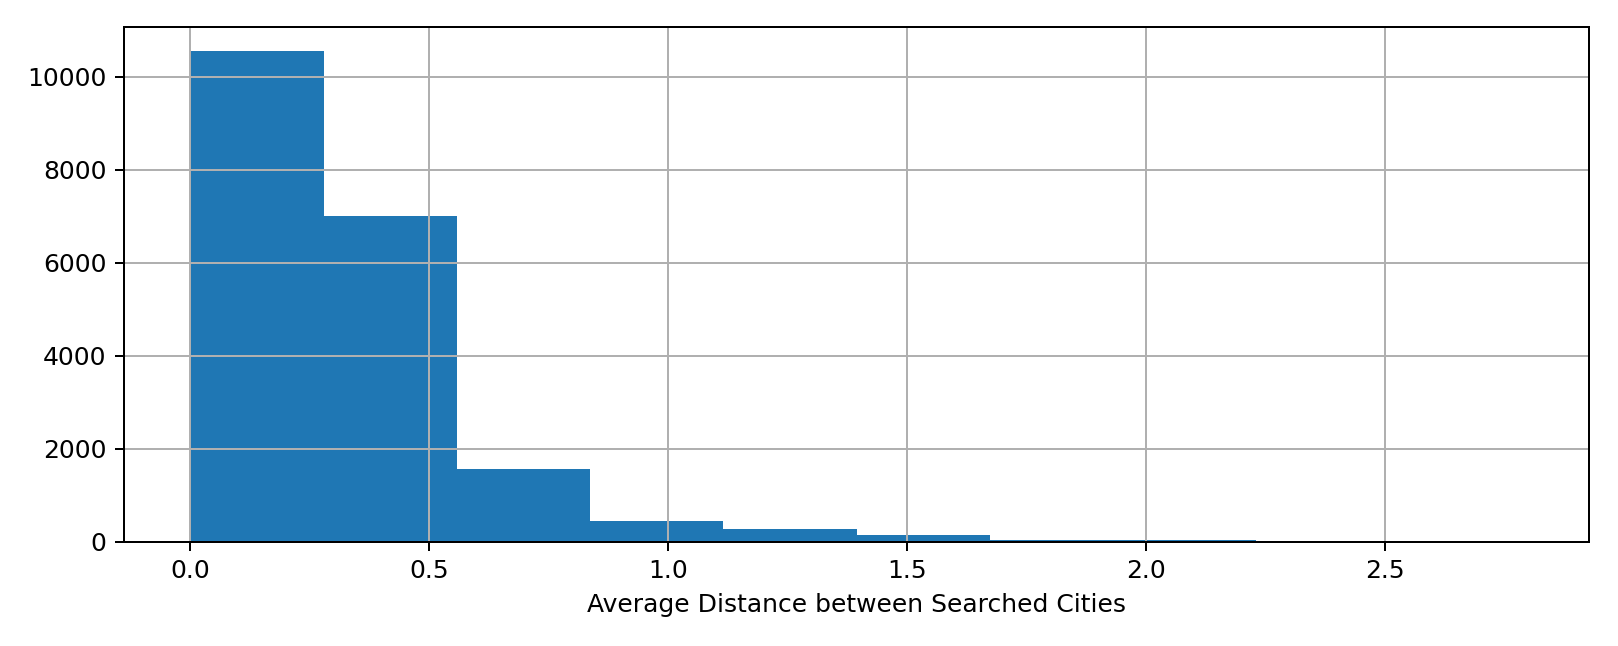

Text(0.5, 0, 'Average Distance between Searched Cities')

In [412]:
%matplotlib notebook
_ = data.cities.map(avg_distance).hist()
plt.xlabel("Average Distance between Searched Cities")

Here I set avg_distance = 0.8 as the cutoff threshold between the low intent and high intent users.

In [414]:
data["avg_distance"] = data.cities.map(avg_distance)
data.loc[data.avg_distance>=0.8, ["user_id", "cities"]]

,user_id,cities
78,1384,"[Anaheim CA, Santa Ana CA, Long Beach CA, Los ..."
82,10713,"[Jersey City NJ, Newark NJ, New York NY, Phila..."
101,3761,"[Portland OR, Edmonton AB, Calgary AB]"
103,5575,"[Seattle WA, Victoria BC, Vancouver BC, Calgar..."
161,3689,"[Miami FL, Hialeah FL, Saint Petersburg FL, Ta..."
...,...,...
19882,814,"[Kitchener ON, Hamilton ON, Saint Catharines-N..."
19894,9447,"[Buffalo NY, Detroit MI, Cleveland OH, Pittsbu..."
19912,10319,"[Victoria BC, Seattle WA, Vancouver BC, Portla..."
19987,5970,"[Saint Catharines-Niagara ON, Buffalo NY, Toro..."


In [415]:
data.loc[data.avg_distance<0.8, ["user_id", "cities"]]

,user_id,cities
0,5749,"[San Jose CA, Montreal QC]"
1,10716,[New York NY]
2,2941,"[Montreal QC, Quebec QC]"
3,2164,[Chicago IL]
4,10493,"[Toronto ON, Houston TX]"
...,...,...
20017,2636,[Phoenix AZ]
20018,8144,[OTTAWA ON]
20019,4816,[Indianapolis IN]
20020,6812,[Chicago IL]


Using above metric and criterion, I found 1079 sessions that have high intent and 18943 sessions that have low intent.